<a href="https://colab.research.google.com/github/asatzger/deep_hedging/blob/main/pfhedge_exercises_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install pfhedge

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import torch

In [19]:
seaborn.set_style("whitegrid")

FONTSIZE = 18
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

In [20]:
torch.manual_seed(25334)

if not torch.cuda.is_available():
    raise RuntimeWarning(
        "CUDA is not available. "
        "If you're using Google Colab, you can enable GPUs as: "
        "https://colab.research.google.com/notebooks/gpu.ipynb"
    )

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Default device:", DEVICE)

Default device: cuda:0


In [21]:
# In each epoch, N_PATHS brownian motion time-series are generated.
N_PATHS = 50000
# How many times a model is updated in the experiment.
N_EPOCHS = 200

In [22]:
def to_numpy(tensor: torch.Tensor) -> np.array:
    return tensor.cpu().detach().numpy()

We consider a `BrownianStock`, which is a stock following the geometric Brownian motion, and a `EuropeanOption` which is contingent on it.

We assume that the stock has a transaction cost given by `cost` (cost = $10^-4$ corresponds to a proportional transaction cost of 1 basis point).

In [23]:
from pfhedge.instruments import BrownianStock, EuropeanOption

stock = BrownianStock(cost=1e-3) # 10 bps transaction cost
derivative = EuropeanOption(stock).to(DEVICE)

In [24]:
derivative

EuropeanOption(
  strike=1., maturity=0.0800
  (underlier): BrownianStock(sigma=0.2000, cost=0.0010, dt=0.0040, device='cuda:0')
)

## Hedger Creation
We compare the performance of Imaki et al (2021)'s efficient neural network model for efficient deep hedging where rebalancing only happens when a certain band around the previous epoch's hedge ratio $\delta_t$ is exceeded (better results than simple feed-forward model proposed by Buehler et al (2019)) with the model hedge, the Black-Scholes delta-hedging strategy (adjusting every epoch to match delta of underlying).

### Black-Scholes delta hedging strategy

In [25]:
from pfhedge.nn import Hedger
from pfhedge.nn import BlackScholes
from pfhedge.nn import ExpectedShortfall


model = BlackScholes(derivative)
hedger = Hedger(model, inputs=model.inputs(), criterion=ExpectedShortfall(0.01)).to(DEVICE)


In [26]:
hedger

Hedger(
  inputs=['log_moneyness', 'time_to_maturity', 'volatility']
  (model): BSEuropeanOption(strike=1.)
  (criterion): ExpectedShortfall(0.01)
)

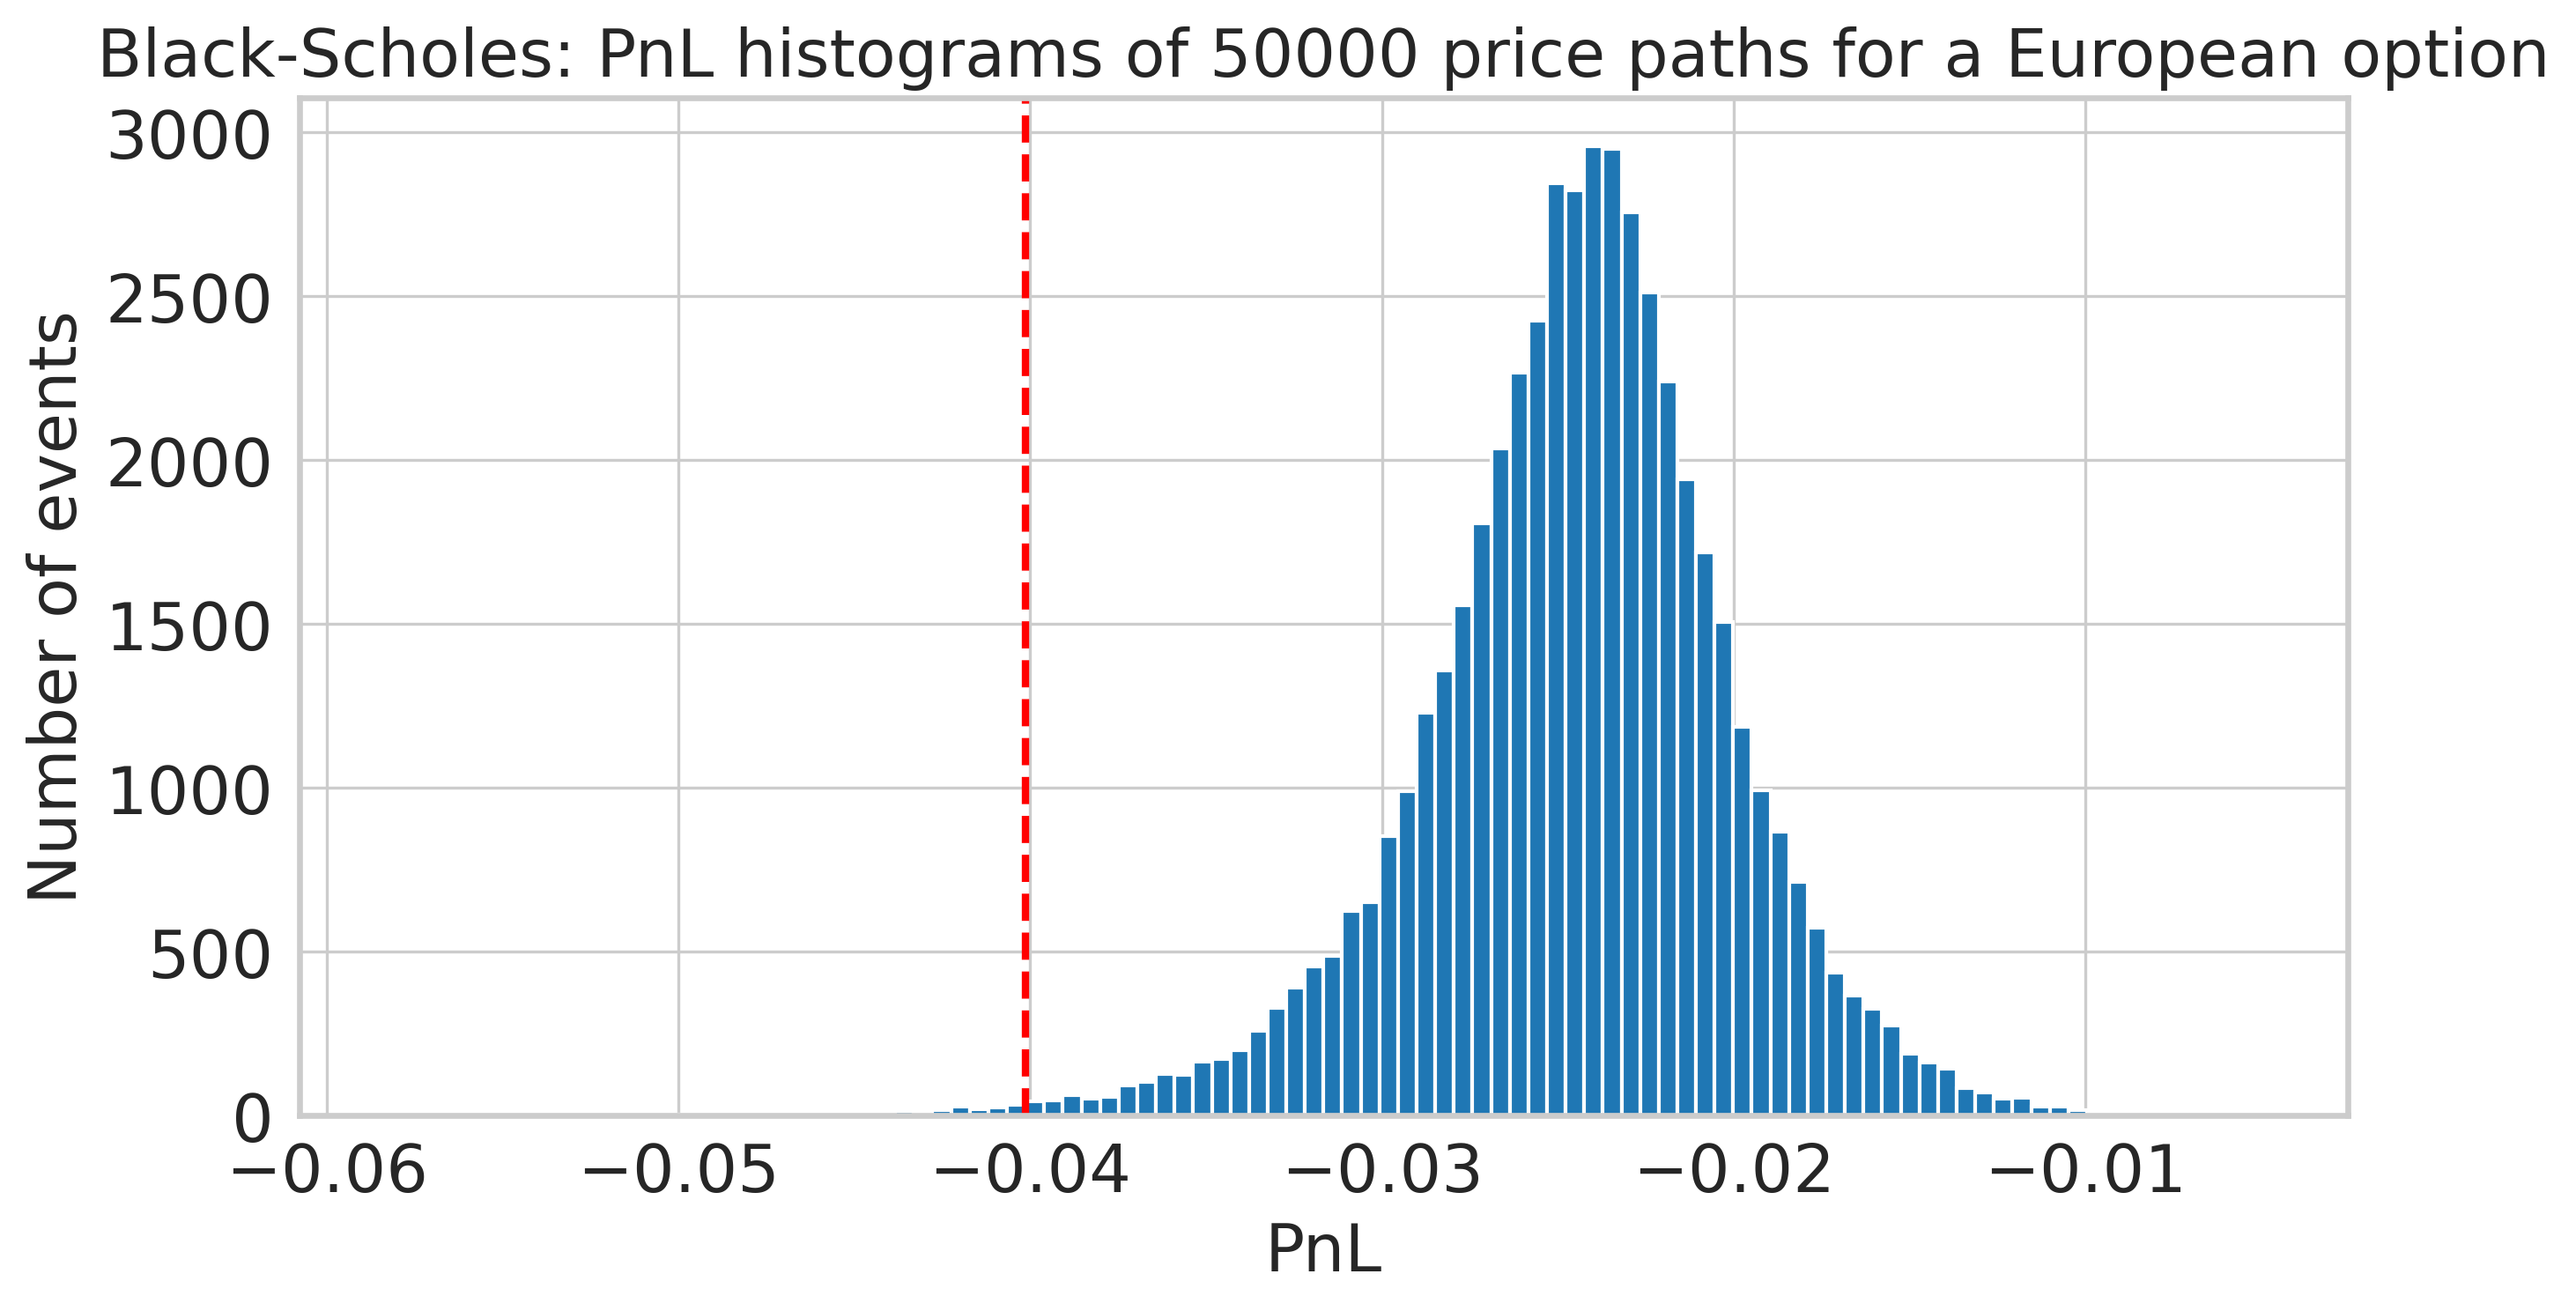

In [27]:
# Compute PnL across simulations
pnl = hedger.compute_pnl(derivative, n_paths=N_PATHS)

# Compute loss under risk measure
loss = hedger.compute_loss(derivative, n_paths=N_PATHS)
loss.item()

plt.figure()
plt.hist(to_numpy(pnl), bins=100)
plt.title("Black-Scholes: PnL histograms of 50000 price paths for a European option")
plt.xlabel("PnL")
plt.ylabel("Number of events")
plt.axvline(x=-loss.item(), color='red', linestyle='--')
plt.show()


In [28]:
# Compute loss under risk measure (expected 99% shortfall)
hedger.compute_loss(derivative, n_paths=50000)

tensor(0.0400, device='cuda:0')

### No-Transaction Band Network

In [29]:
import torch.nn.functional as fn
from torch import Tensor
from torch.nn import Module

from pfhedge.nn import BlackScholes, Clamp, MultiLayerPerceptron


class NoTransactionBandNet(Module):
    def __init__(self, derivative):
        super().__init__()

        self.delta = BlackScholes(derivative)
        self.mlp = MultiLayerPerceptron(out_features=2)
        self.clamp = Clamp()

    def inputs(self):
        return self.delta.inputs() + ["prev_hedge"]

    def forward(self, input: Tensor) -> Tensor:
        prev_hedge = input[..., [-1]]

        delta = self.delta(input[..., :-1])
        width = self.mlp(input[..., :-1])

        min = delta - fn.leaky_relu(width[..., [0]])
        max = delta + fn.leaky_relu(width[..., [1]])

        return self.clamp(prev_hedge, min=min, max=max)

In [30]:
model = NoTransactionBandNet(derivative)
hedger = Hedger(model, inputs=model.inputs(), criterion=ExpectedShortfall(0.01)).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [31]:
history = hedger.fit(derivative, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

Loss=0.0379: 100%|██████████| 200/200 [03:55<00:00,  1.18s/it]


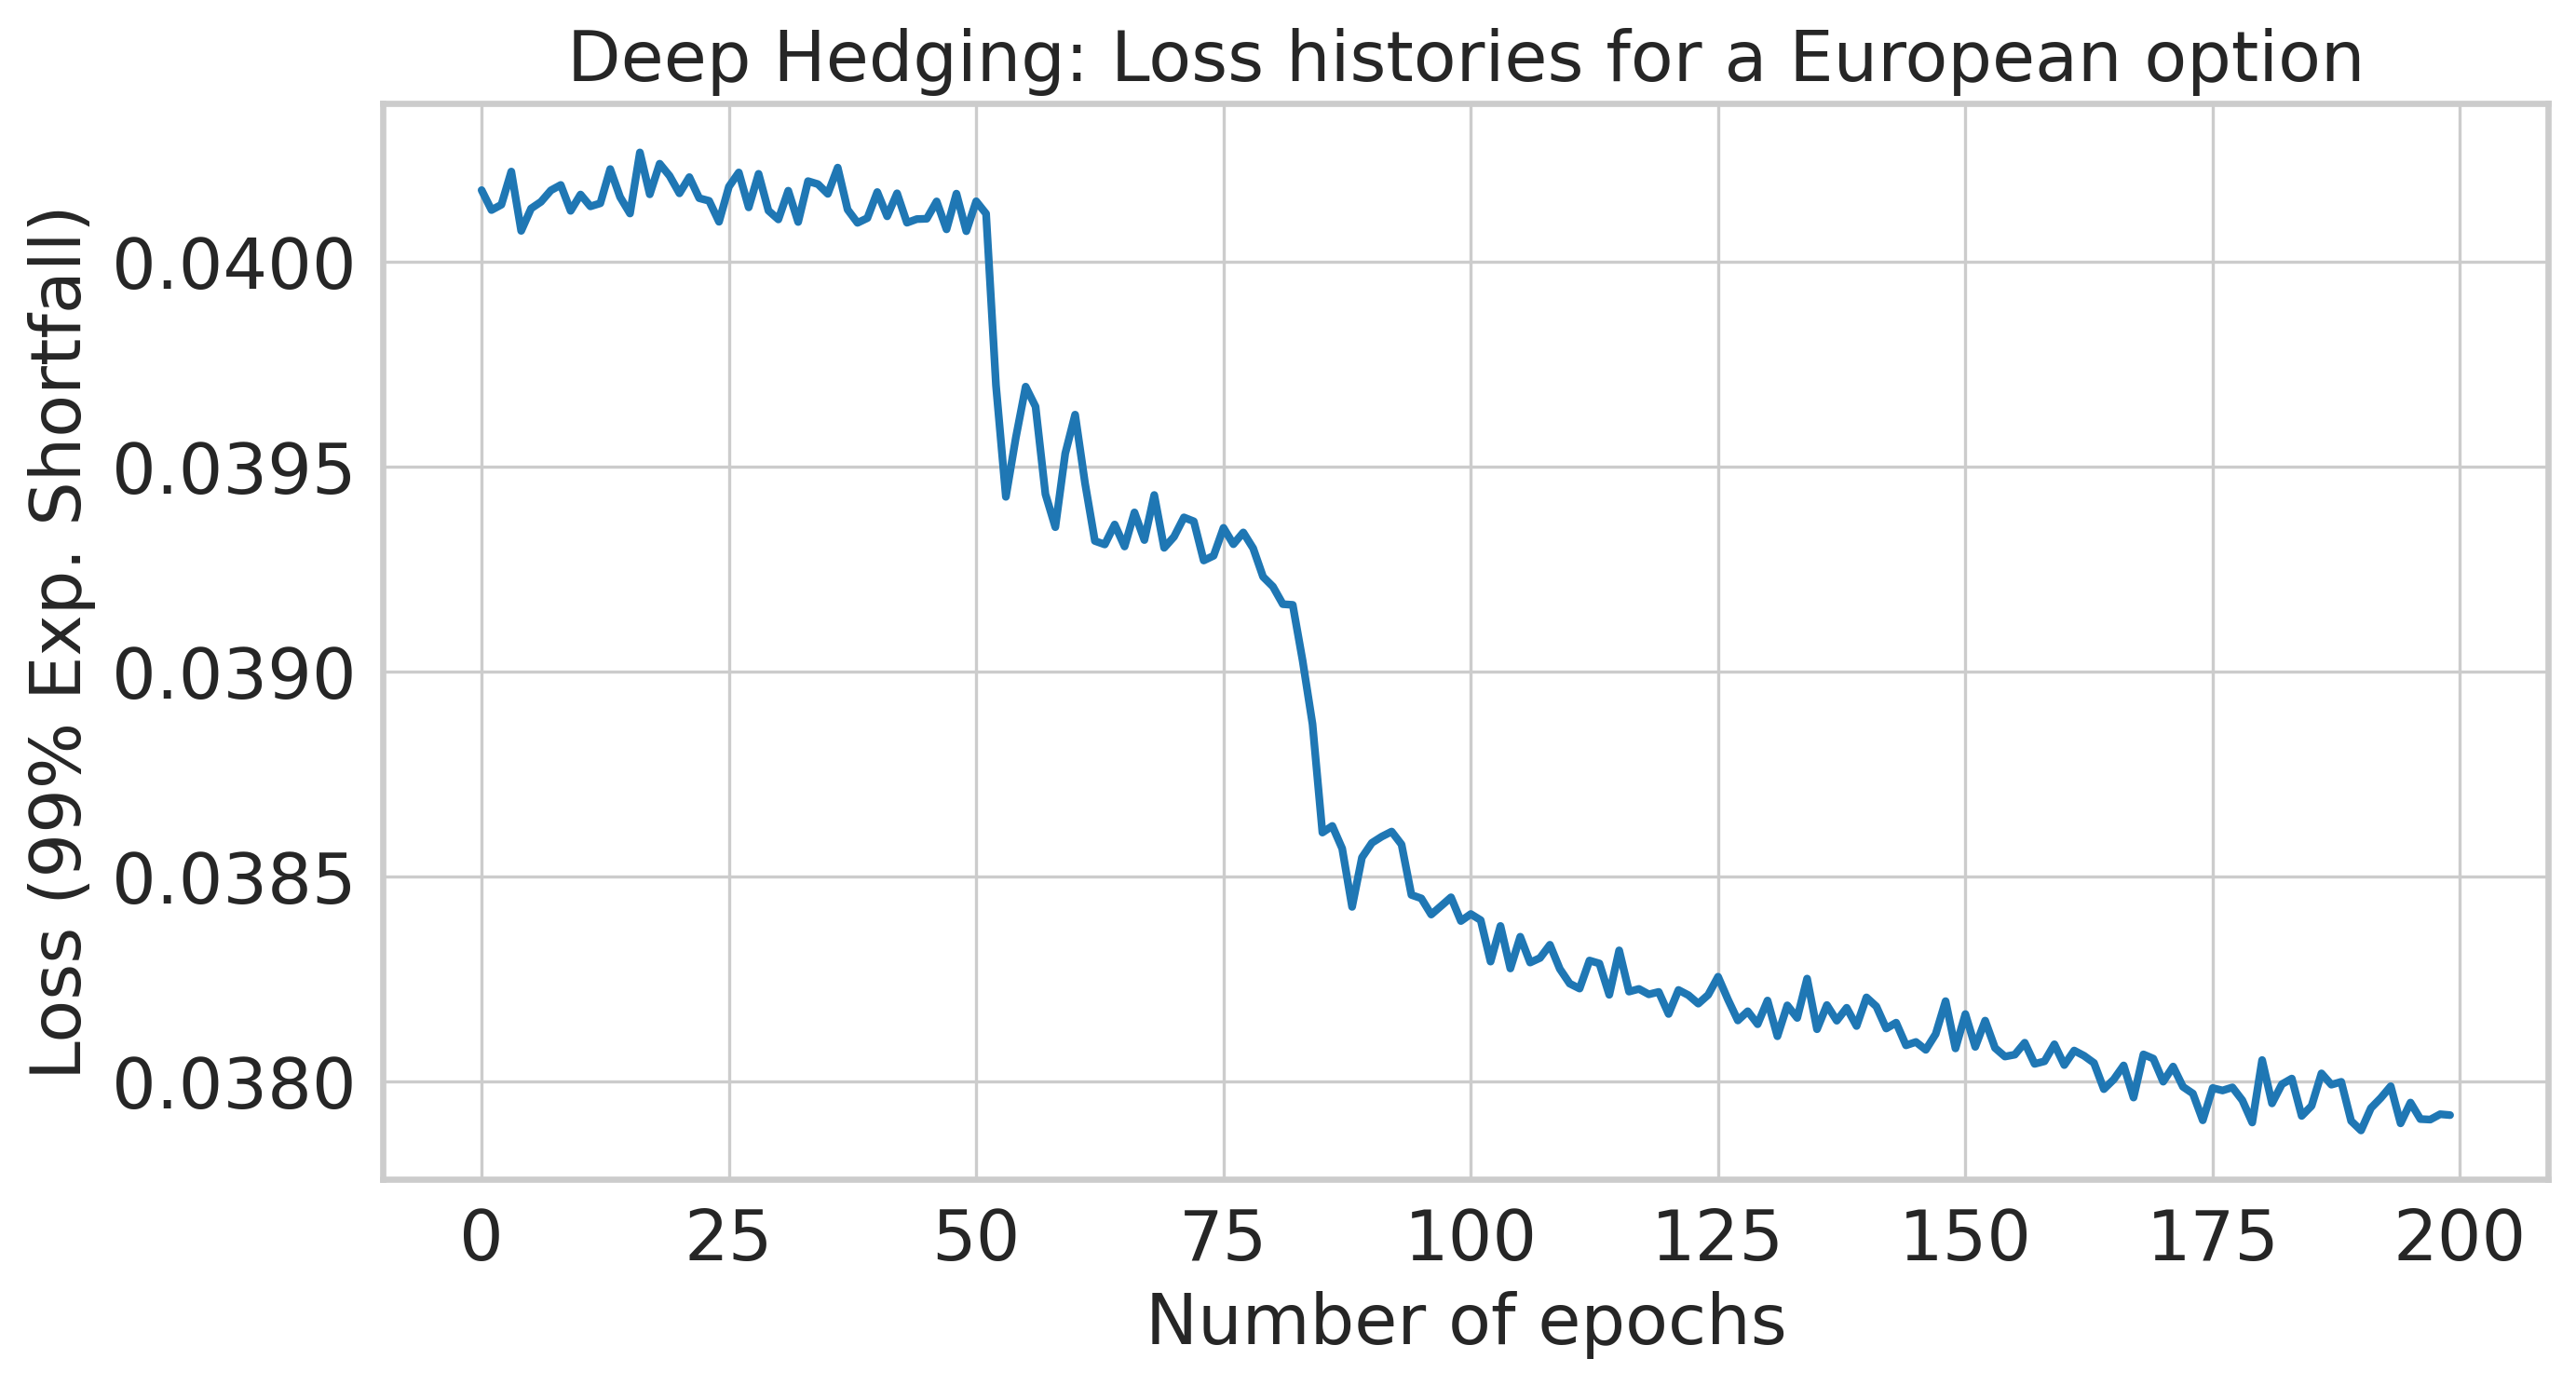

In [32]:
plt.plot(history)
plt.xlabel("Number of epochs")
plt.ylabel("Loss (99% Exp. Shortfall)")
plt.title("Deep Hedging: Loss histories for a European option")
plt.show()

In [33]:
hedger
derivative

EuropeanOption(
  strike=1., maturity=0.0800
  (underlier): BrownianStock(sigma=0.2000, cost=0.0010, dt=0.0040, device='cuda:0')
)

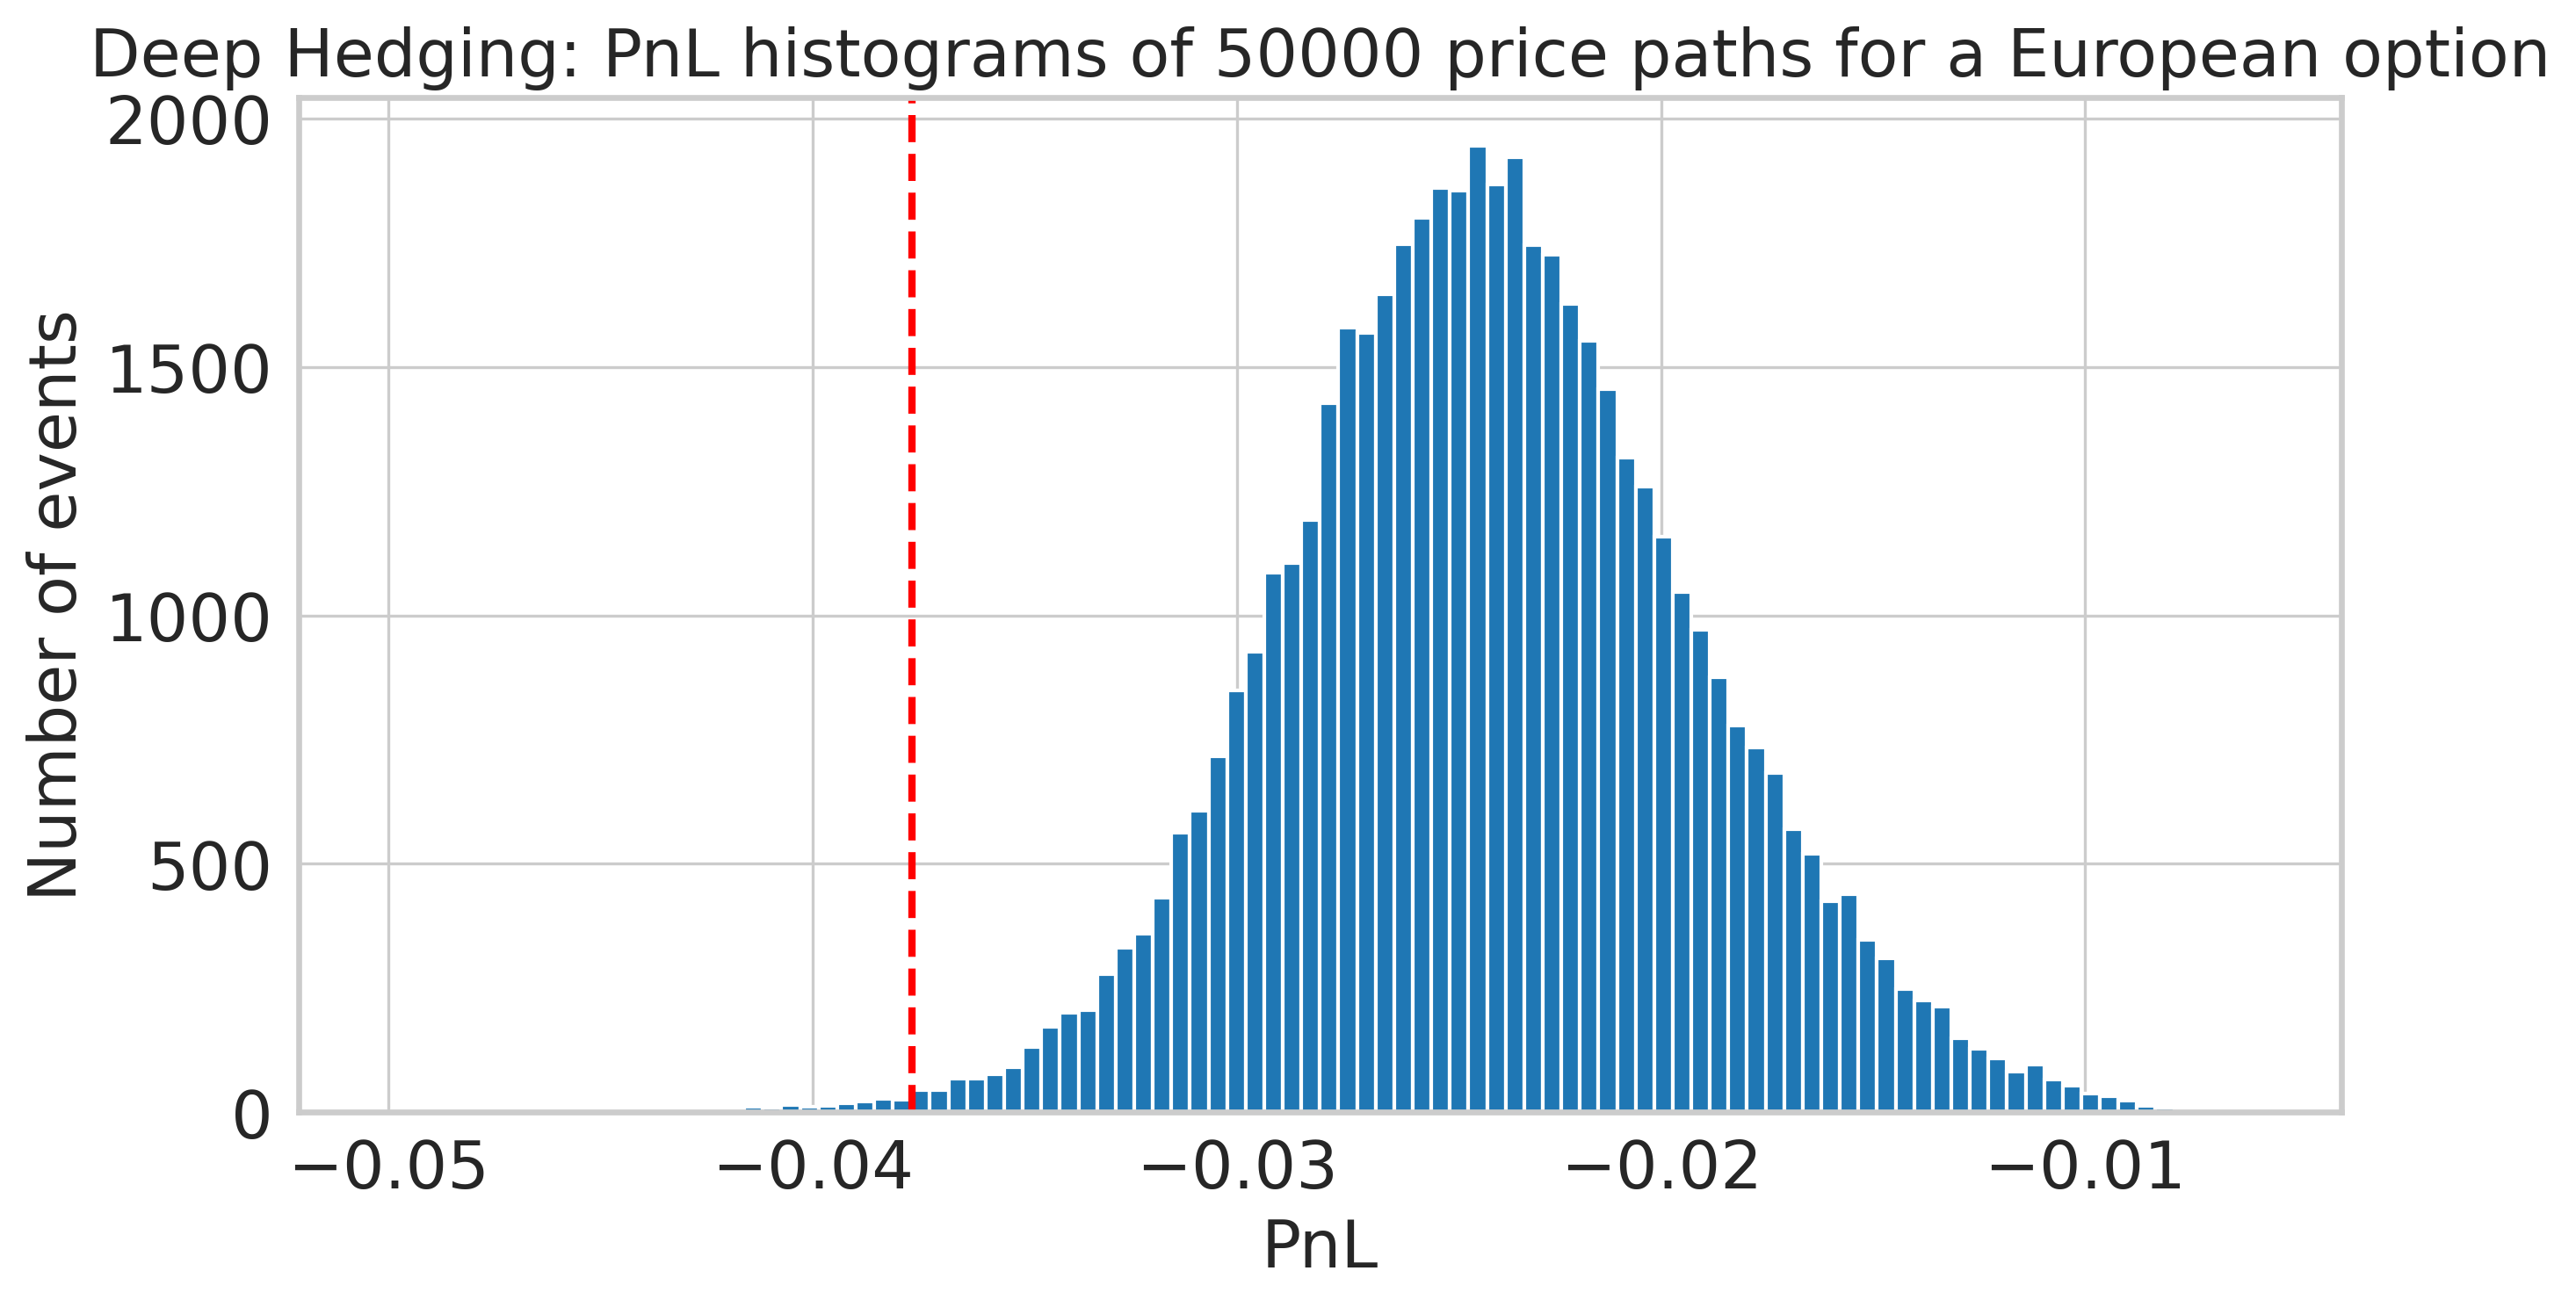

In [34]:
pnl = hedger.compute_pnl(derivative, n_paths=N_PATHS)
loss = hedger.compute_loss(derivative, n_paths=N_PATHS)

plt.figure()
plt.hist(to_numpy(pnl), bins=100)
plt.title("Deep Hedging: PnL histograms of 50000 price paths for a European option")
plt.xlabel("PnL")
plt.ylabel("Number of events")
plt.axvline(x=-loss.item(), color='red', linestyle='--')
plt.show()

In [ ]:
pnl
loss